In [12]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


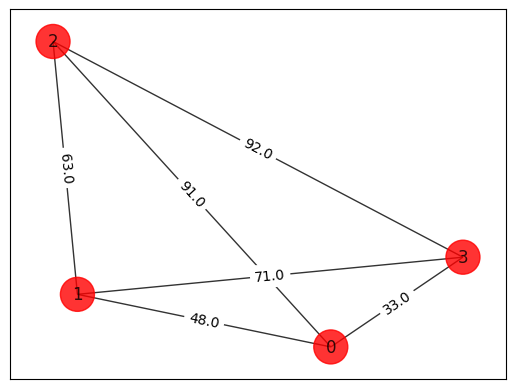

In [41]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# Generating a graph of 3 nodes
n = 4
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

order = (0, 1, 2, 3) Distance = 236.0
Best order from brute force = (0, 1, 2, 3) with total distance = 236.0


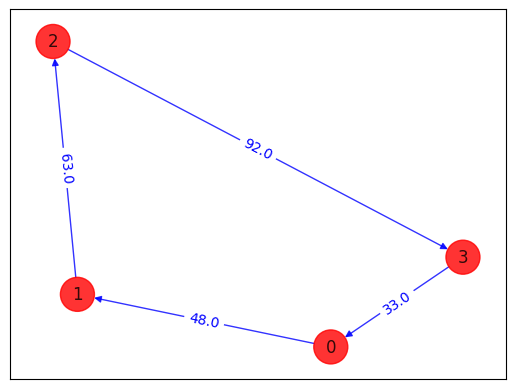

In [42]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

In [43]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())


Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

In [74]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
#print(str(qubitOp))

Offset: 51756.0
Ising Hamiltonian:


In [95]:
qubitOp.paulis

PauliList(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII',
           'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII',
           'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII',
           'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII',
           'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII',
           'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ',
           'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIZIIIIZ',
           'IIIIIIIIZIIIIIIZ', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIIIZ',
           'IIIIZIIIIIIIIIIZ', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIZ',
           'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIZI',
           'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIZIIIIZI',
           'IIIIIIIZIIIIIIZI', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIIIZI',
           'IIIZIIIIIIIIIIZI', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIIIZI',
           'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIZII',
      

In [104]:
coeffs = qubitOp.coeffs

qubo_matrix = np.zeros((n**2, n**2))

for i in range(len(qubitOp.paulis)):
    # find position of first Z
    pauli_string = str(qubitOp.paulis[i])
    x = pauli_string.index("Z")
    y = x
    # check if their is another Z
    if pauli_string.count("Z") > 1:
        y = pauli_string.index("Z", x + 1)

    # find coefficient
    qubo_matrix[x, y] = coeffs[i]

for line in range(16):
    for num in range(16):
        print(f" {qubo_matrix[line, num]}", end="")
    print()

 -6468.0 1592.5 1592.5 1592.5 1592.5 23.0 0.0 23.0 1592.5 17.75 0.0 17.75 1592.5 8.25 0.0 8.25
 0.0 -6468.0 1592.5 1592.5 23.0 1592.5 23.0 0.0 17.75 1592.5 17.75 0.0 8.25 1592.5 8.25 0.0
 0.0 0.0 -6468.0 1592.5 0.0 23.0 1592.5 23.0 0.0 17.75 1592.5 17.75 0.0 8.25 1592.5 8.25
 0.0 0.0 0.0 -6468.0 23.0 0.0 23.0 1592.5 17.75 0.0 17.75 1592.5 8.25 0.0 8.25 1592.5
 0.0 0.0 0.0 0.0 -6493.0 1592.5 1592.5 1592.5 1592.5 15.75 0.0 15.75 1592.5 22.75 0.0 22.75
 0.0 0.0 0.0 0.0 0.0 -6493.0 1592.5 1592.5 15.75 1592.5 15.75 0.0 22.75 1592.5 22.75 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 -6493.0 1592.5 0.0 15.75 1592.5 15.75 0.0 22.75 1592.5 22.75
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -6493.0 15.75 0.0 15.75 1592.5 22.75 0.0 22.75 1592.5
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -6461.0 1592.5 1592.5 1592.5 1592.5 12.0 0.0 12.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -6461.0 1592.5 1592.5 12.0 1592.5 12.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -6461.0 1592.5 0.0 12.0 1592.5 12.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -64

/tmp/ipykernel_26892/363910000.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  qubo_matrix[x, y] = coeffs[i]


In [86]:
from cudaq import spin


print(len(coeffs))

num_qubits = 16

# Initialize the Hamiltonian
hamiltonian = 0

qubo_matrix = np.zeros((n**2, n**2))

linear_coeff = []

# First loop for single-qubit Z terms
for i in range(num_qubits):
    hamiltonian += coeffs[i] * spin.z(i)
    qubo_matrix[i, i] = coeffs[i]

# Second loop for multi-qubit ZZ and higher terms
current_coeff_index = num_qubits  # Start from the next coefficient after single-qubit terms

for i in range(num_qubits):
    for j in range(i + 1, num_qubits):
        print(j)
        hamiltonian += coeffs[current_coeff_index] * spin.z(i) * spin.z(j)
        qubo_matrix[i, j] = coeffs[current_coeff_index]
        current_coeff_index += 1

print(current_coeff_index)

112
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
2
3
4
5
6
7
8
9
10
11
12
13
14
15
3
4
5
6
7
8
9
10
11
12
13
14
15
4
5
6
7
8
9
10
11
12
13
14
15
5
6
7
8
9
10
11
12
13
14
15
6
7
8
9
10
11
12
13
14
15
7
8
9
10
11
12
13
14
15
8
9
10
11
12
13
14
15
9
10
11
12
13
14
15
10
11
12
13
14
15
11
12
13
14
15
12
13
14
15
13
14
15
14
15
15
136


/tmp/ipykernel_26892/3621563963.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  qubo_matrix[i, i] = coeffs[i]


In [40]:
print(qubo_matrix)

[[-1282.5    606.5    606.5    606.5     12.      12.     606.5     22.75
     22.75]
 [    0.   -1282.5    606.5     12.     606.5     12.      22.75   606.5
     22.75]
 [    0.       0.   -1282.5     12.      12.     606.5     22.75    22.75
    606.5 ]
 [    0.       0.       0.   -1268.5    606.5    606.5    606.5     15.75
     15.75]
 [    0.       0.       0.       0.   -1268.5    606.5     15.75   606.5
     15.75]
 [    0.       0.       0.       0.       0.   -1268.5     15.75    15.75
    606.5 ]
 [    0.       0.       0.       0.       0.       0.   -1290.     606.5
    606.5 ]
 [    0.       0.       0.       0.       0.       0.       0.   -1290.
    606.5 ]
 [    0.       0.       0.       0.       0.       0.       0.       0.
  -1290.  ]]
